In [1]:
import numpy as np
import open3d as o3d
import copy
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

references:

> https://stackoverflow.com/questions/47932955/how-to-check-if-a-3d-point-is-inside-a-cylinder
> https://math.stackexchange.com/questions/3518495/check-if-a-general-point-is-inside-a-given-cylinder

## File IO

In [2]:
stl_mesh = o3d.io.read_triangle_mesh("stl_mesh.stl")
obj_mesh = o3d.io.read_triangle_mesh("obj_mesh.obj")

## Visualization

In [3]:
mesh = obj_mesh
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])

In [4]:
# o3d.visualization.draw_geometries([mesh, mesh_frame])

In [5]:
# scaled_mesh = copy.deepcopy(mesh)
# scaled_mesh.scale(1 / np.max(scaled_mesh.get_max_bound() - scaled_mesh.get_min_bound()), center=scaled_mesh.get_center())
# o3d.visualization.draw_geometries([scaled_mesh, mesh_frame])

## Normalization

### Center the Mesh

In [6]:
print(mesh.get_center())
centered_vertices = np.array(mesh.vertices) - mesh.get_center()
mesh.vertices = o3d.utility.Vector3dVector(centered_vertices)
print(mesh.get_center())

[ 0.72569102 -0.68593362 10.31785828]
[-7.68295749e-13 -6.04510797e-13 -5.92657940e-12]


### Scale the Points

In [7]:
print(mesh.get_min_bound(), mesh.get_max_bound())
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
print(mesh.get_min_bound(), mesh.get_max_bound())

[-33.08519572  -4.25436637 -42.67735916] [31.63381368  2.27343359 75.54260773]
[-0.27986132 -0.03598687 -0.36099959] [0.26758436 0.01923054 0.63900041]


In [8]:
# o3d.visualization.draw_geometries([mesh, mesh_frame])

## Voxelization and Holes

### V1: Using 3D Points and  Voxels

In [140]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.02)
# o3d.visualization.draw_geometries([voxel_grid])

In [ ]:
voxels = np.array(list(map(lambda x: x.grid_index, voxel_grid.get_voxels())))

In [2]:
def points_in_cylinder(pt1, pt2, radius, points):
    """
    find the points in a cylinder
    :pt1: 1st bounding point of the cylinder
    :pt2: 2nd bounding point of the cylinder
    :radius: radius of the cylinder
    :points: NumPy array of 3D points
    :return: NumPy boolean array of points inside of cylinder
    """
    vec = pt2 - pt1
    const = radius * np.linalg.norm(vec)
    cond1 = np.dot(points - pt1, vec) >= 0
    cond2 = np.dot(points - pt2, vec) <= 0
    cond3 = np.linalg.norm(np.cross(points - pt1, vec), axis=1) <= const
    
    cond4 = np.logical_and(cond1, cond2)
    cond5 = np.logical_and(cond3, cond4)
    return cond5

In [48]:
points = np.asarray(mesh.vertices)

maxx = np.max(points, axis=0)
minn = np.min(points, axis=0)

pt1 = voxel_grid.get_center()
pt2 = voxel_grid.get_center()

idx = 2
pt1[idx] =  minn[idx]
pt2[idx] =  maxx[idx]

In [49]:
idx = points_in_cylinder(pt1, pt2, 0.05, points)
to_be_removed = points[idx]

In [50]:
voxels_to_be_removed = np.unique(list(map(lambda x: voxel_grid.get_voxel(x), to_be_removed)), axis = 0)

In [51]:
# voxels_to_be_removed = list(map(lambda x: o3d.geometry.Voxel(x), voxels_to_be_removed))

In [52]:
N = voxels.max()
voxels_occ_grid = np.zeros((N,N,N))

In [53]:
for v in voxels:
    voxels_occ_grid[v[0]-1, v[1]-1, v[2]-1] = 1

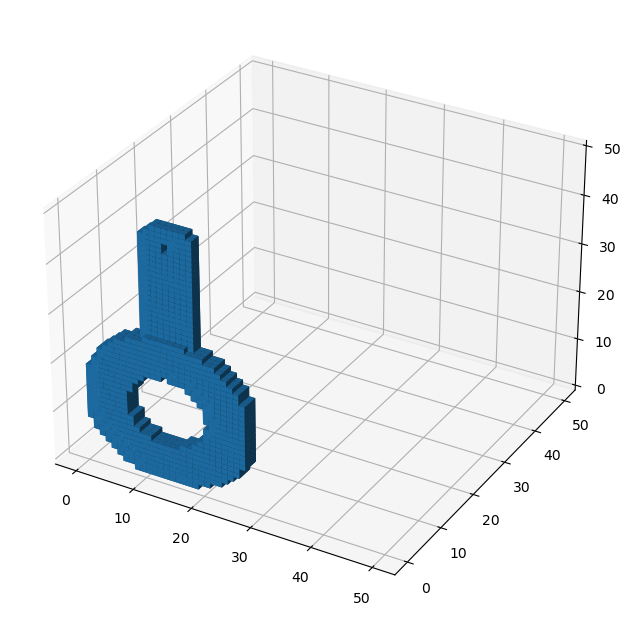

In [54]:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
ax.voxels(voxels_occ_grid)
plt.show()

In [55]:
for v in voxels_to_be_removed:
    voxels_occ_grid[v[0]-1, v[1]-1, v[2]-1] = 0

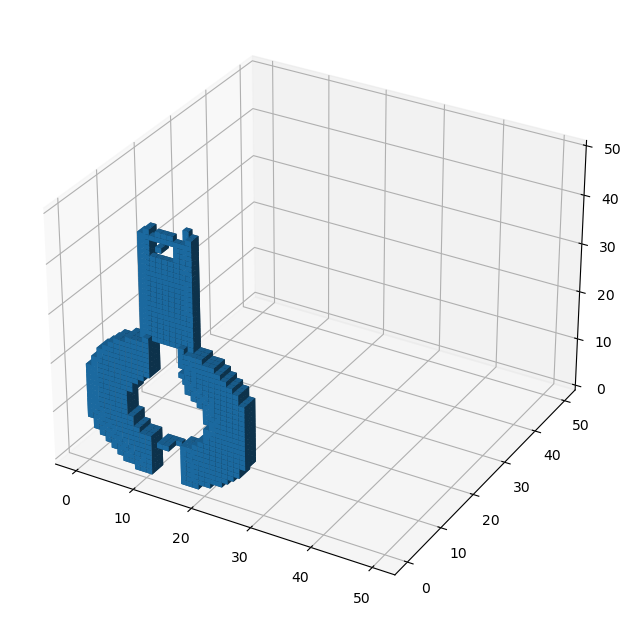

In [56]:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
ax.voxels(voxels_occ_grid)
plt.show()

### V2: Using Voxels

In [39]:
# get the voxel grid indices out of the occupancy grid
model = np.load("2.npz")['model']
voxels = np.argwhere(model == 1)

In [40]:
# fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
# ax = fig.gca(projection='3d')
# ax.voxels(model)
# plt.show()

In [41]:
def find_radius(voxels, cylinder_axis):
    """
    find an appropriate radius for the cylinder
    :voxels: voxel grid indices
    :cylinder_axis: axis of the cylinder {0, 1, 2}
    :return: selected radius
    """
    # list of possible diameters [1, 10]
    diameters = list(range(10, 0, -1))
    
    # 2d plane perpendicular to the cylinder axis
    plane = list(range(3))
    plane.remove(cylinder_axis)    

    # maximum and minimum grid index 
    maxx = np.max(voxels, axis=0)
    minn = np.min(voxels, axis=0)
    
    # perpendicular plane dimensions 
    fir_dim = maxx[plane[0]] - minn[plane[0]]
    sec_dim = maxx[plane[1]] - minn[plane[1]]
    
    # perpendicular plane smaller dimension
    min_dim = np.min([fir_dim, sec_dim])

    # heuristic: there should be more than 10 voxels after making the hole
    for d in diameters:
        diff = min_dim - d
        if diff > 10:
            return int(d/2)
        
    return None

In [42]:
def find_axis_and_radius(voxels):
    """
    find an appropriate radius for the cylinder
    :voxels: voxel grid indices
    :return: pair: selected axis and radius
    """
    # try out the 3 possible axes
    axis = range(3)
    for a in axis:
    # return 1st axis with largest diameter
        r = find_radius(voxels, a)
        print(a, r)
        if r != None:
            return a, r

In [43]:
# find appropriate axis and radius of the cylinder
axis, radius = find_axis_and_radius(voxels)

0 5


In [44]:
# find center of the voxels grid
center = np.round(voxels.mean(axis = 0))

# maximum and minimum grid index 
maxx = np.max(voxels, axis=0)
minn = np.min(voxels, axis=0)

# set cylinder boundary points to the center
pt1 = copy.deepcopy(center)
pt2 = copy.deepcopy(center)

# change 1 component based on the selected axis
idx = axis
pt1[idx] =  minn[idx]
pt2[idx] =  maxx[idx]

In [45]:
# identify voxels to be removed
idx = points_in_cylinder(pt1, pt2, radius, voxels)
to_be_removed = voxels[idx]

In [46]:
# remove selected voxels from the occupancy grid
for v in to_be_removed:
    model[v[0], v[1], v[2]] = 0

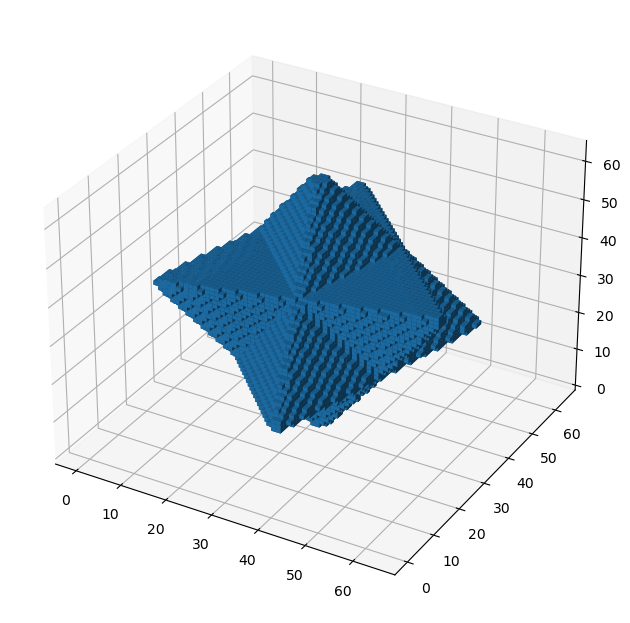

In [47]:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
ax.voxels(model)
plt.show()